# Big Data Project

## Intialising Spark and loading Data

In [1]:
# The code was removed by Watson Studio for sharing.

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20200907145737-0001
KERNEL_ID = ac95bf2a-cb01-495b-ac54-ec48bc121de9


In [2]:
# #Libraries
# from pyspark.sql import functions as F
# from pyspark.sql.types import *
# from pyspark.sql.types import FloatType
# from pyspark.ml.feature import VectorAssembler, VectorIndexer, StandardScaler, OneHotEncoder, Imputer, StringIndexer
# from pyspark.ml import feature
# from pyspark.ml import Pipeline
# from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
# from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
# from pyspark.ml.evaluation import BinaryClassificationEvaluator

# #Other Libraries
# import pandas as pd
# import numpy as np
# import seaborn as sns
# import time
# import matplotlib.pyplot as plt

In [3]:
# Pyspark Libraries
from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import StringIndexer, Imputer
from pyspark.ml import Pipeline

#Other Libraries
import numpy as np
import pandas as pd # for creating dataframes
import matplotlib.pyplot as plt #Basic Plotting
import seaborn as sns #Prettier Plot
from datetime import datetime #to manage time series columns

In [4]:
df.count()

2260668

In [5]:
# We check for null values and print columns only if the have null columns

# droplist = []
# count = df.count()
# for col in df.columns:
#     cnt = df.filter(df[col].isNull()).count()
#     null_per = (cnt/count)*100
#     if null_per < 30:
#         print(col, " ", "with null values: ", cnt)
#         print(col, " ", "with % null values: ", null_per, '%')      
#     else:  
#         droplist.append(col)

In [6]:
droplist = ['url', 'desc', 'mths_since_last_delinq', 'mths_since_last_record', 'next_pymnt_d', 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', \
            'verification_status_joint', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',\
            'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', \
            'revol_bal_joint', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il',\
            'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog', 'hardship_type', \
            'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date',\
            'hardship_length', 'hardship_dpd', 'hardship_loan_status', 'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount', \
            'hardship_last_payment_amount', 'debt_settlement_flag_date', 'settlement_status', 'settlement_date', 'settlement_amount', 'settlement_percentage', \
            'settlement_term']

In [7]:
#Creating list for categorical and numerical features
feat_cat = []
feat_num = []
feat_index = []

# We are going to drop these 56 features because they are missing more than 30% of their values
print('The number of Columns we will Drop :', len(droplist))
red_df = df.drop(*droplist)

The number of Columns we will Drop : 56


In [8]:
# red_df = red_df.fillna()

In [9]:
# red_df.printSchema()

In [10]:
a4_dims = (11.7, 8.27)

# Exploratory Data Analysis

### Defaulters (Label) 

We convert it into binary whether the loan is Good or Bad 

In [11]:
df.select('loan_status').distinct().show(truncate = False)

+---------------------------------------------------+
|loan_status                                        |
+---------------------------------------------------+
|Fully Paid                                         |
|Default                                            |
|In Grace Period                                    |
|Does not meet the credit policy. Status:Fully Paid |
|Charged Off                                        |
|Oct-2015                                           |
|Late (31-120 days)                                 |
|Current                                            |
|Does not meet the credit policy. Status:Charged Off|
|Late (16-30 days)                                  |
+---------------------------------------------------+



In [12]:
red_df = red_df.where(~red_df.loan_status.isin(['Oct-2015']))
red_df = red_df.withColumn("Default", 
   F.when((red_df.loan_status == 'Fully Paid') | (red_df.loan_status == 'Current') | (red_df.loan_status == 'Does not meet the credit policy. Status:Fully Paid') ,'Good Loan').otherwise('Bad Loan'))

red_df = red_df.drop('loan_status')


red_df.groupBy(['Default']).count().orderBy('count', ascending = False).show(10,  truncate = False)

+---------+-------+
|Default  |count  |
+---------+-------+
|Good Loan|1963635|
|Bad Loan |297032 |
+---------+-------+



Data is Skewed by 1 : 6.67, hence AUC will be used as Evaluvation Metrics

Text(0, 0.5, 'Number of Customers')

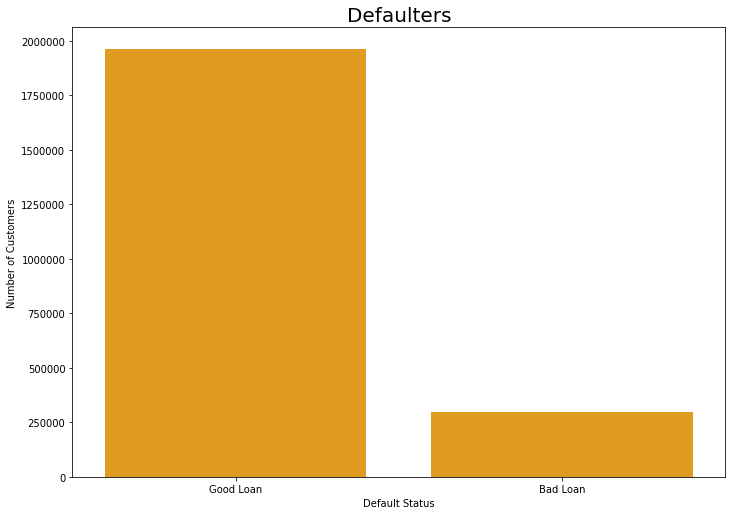

In [13]:
default = red_df.select('Default').toPandas()

fig, ax = plt.subplots(figsize = a4_dims)

sns.countplot(x = 'Default', data = default)
ax.set_title('Defaulters', fontsize = 20)
ax.set_xlabel('Default Status')
ax.set_ylabel('Number of Customers')

## Features

### 1. Loaned and Invested Amount
- Loan Amount
- Funded Amount
- Amount Invested

In [14]:
#These numerical features dont have missing values
feat_num.extend(['loan_amnt', 'funded_amnt', 'funded_amnt_inv'])

red_df.describe('loan_amnt', 'funded_amnt', 'funded_amnt_inv').show()

+-------+------------------+-----------------+------------------+
|summary|         loan_amnt|      funded_amnt|   funded_amnt_inv|
+-------+------------------+-----------------+------------------+
|  count|           2260667|          2260667|           2260667|
|   mean|15046.933239172333|15041.66606581155|15023.439624591398|
| stddev| 9190.247023316111|9188.414558113096| 9192.333347425249|
|    min|               500|              500|               0.0|
|    max|             40000|            40000|           40000.0|
+-------+------------------+-----------------+------------------+



Text(0, 0.5, 'Number of Customers')

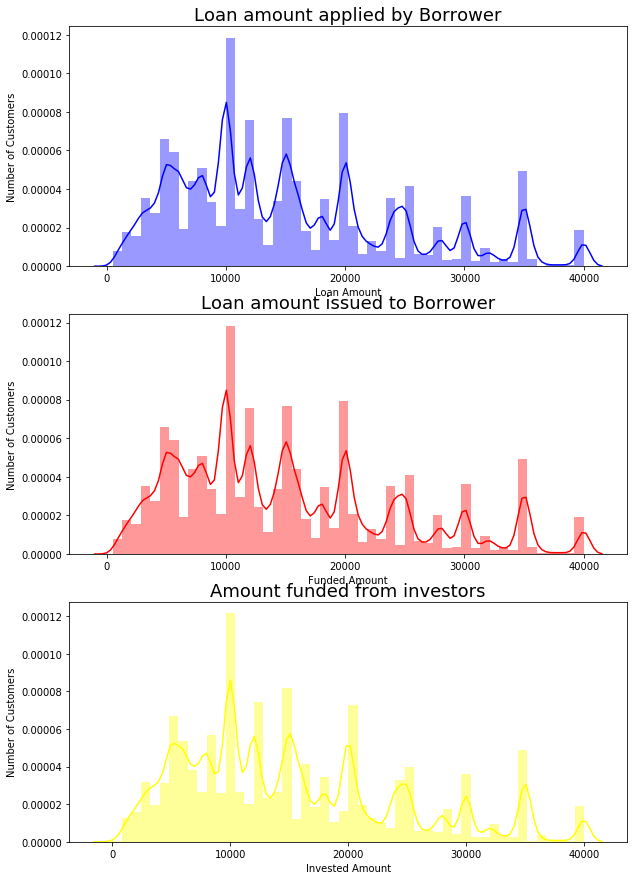

In [15]:
loan = red_df.select('loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate').toPandas()

fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (10,15))

sns.distplot(loan['loan_amnt'] , color = 'blue', ax = ax[0])
ax[0].set_title('Loan amount applied by Borrower', fontsize = 18)
ax[0].set_xlabel('Loan Amount')
ax[0].set_ylabel('Number of Customers')

sns.distplot(loan['funded_amnt'] , color = 'red', ax = ax[1])
ax[1].set_title('Loan amount issued to Borrower', fontsize = 18)
ax[1].set_xlabel('Funded Amount')
ax[1].set_ylabel('Number of Customers')

sns.distplot(loan['funded_amnt_inv'] , color = 'yellow', ax = ax[2])
ax[2].set_title('Amount funded from investors', fontsize = 18)
ax[2].set_xlabel('Invested Amount')
ax[2].set_ylabel('Number of Customers')

In [16]:
feat_num

['loan_amnt', 'funded_amnt', 'funded_amnt_inv']

### 2. Term Length

In [19]:
red_df.groupBy(['term']).count().orderBy('count', ascending = False).show()

+----------+-------+
|      term|  count|
+----------+-------+
| 36 months|1609754|
| 60 months| 650913|
+----------+-------+



In [20]:
feat_cat.append('term')

### 3. Interest Rate


In [22]:
red_df.describe('int_rate').show()

+-------+------------------+
|summary|          int_rate|
+-------+------------------+
|  count|           2260667|
|   mean|13.092913874545054|
| stddev| 4.832115099195692|
|    min|              5.31|
|    max|             30.99|
+-------+------------------+



Text(0, 0.5, 'Number of Customers')

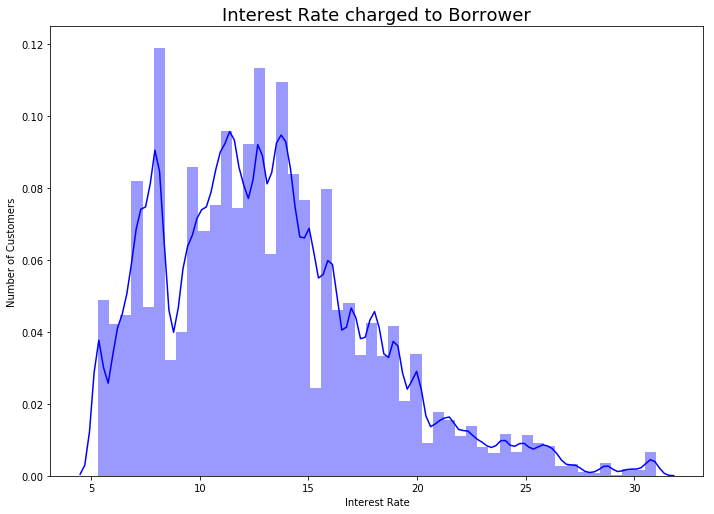

In [26]:
int_rate = red_df.select('int_rate').toPandas()

fig, ax = plt.subplots(figsize = a4_dims)

sns.distplot(int_rate['int_rate'] , color = 'blue')
ax.set_title('Interest Rate charged to Borrower', fontsize = 18)
ax.set_xlabel('Interest Rate')
ax.set_ylabel('Number of Customers')

In [27]:
feat_num.append('int_rate')

### 4. Installment 

In [28]:
red_df.describe('installment').show()

+-------+------------------+
|summary|       installment|
+-------+------------------+
|  count|           2260667|
|   mean| 445.8077421619591|
| stddev|267.17374490328854|
|    min|              4.93|
|    max|           1719.83|
+-------+------------------+



Text(0, 0.5, 'Number of Customers')

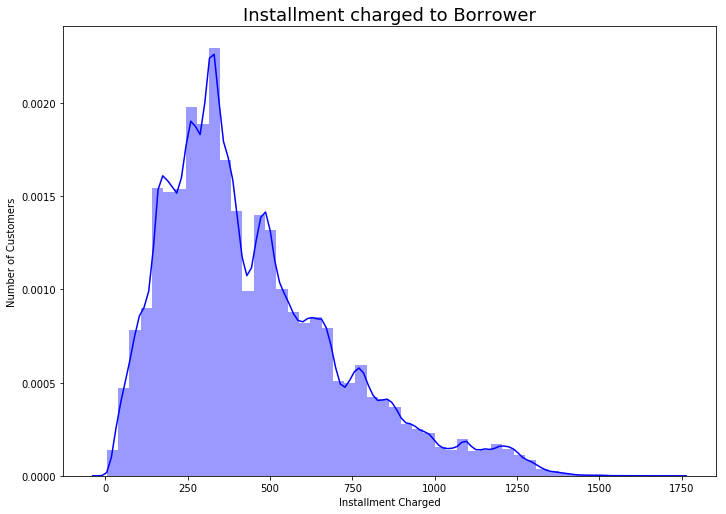

In [29]:
inst = red_df.select('installment', 'Default').toPandas()

fig, ax = plt.subplots(figsize = a4_dims)

sns.distplot(inst['installment'] , color = 'blue')
ax.set_title('Installment charged to Borrower', fontsize = 18)
ax.set_xlabel('Installment Charged')
ax.set_ylabel('Number of Customers')

In [ ]:
feat_num.append('installment')

### 5. Grade and Subgrade

In [ ]:
red_df.groupBy('grade', 'sub_grade').count().orderBy('count', ascending = False).show()

+-----+---------+------+
|grade|sub_grade| count|
+-----+---------+------+
|    C|       C1|145903|
|    B|       B5|140288|
|    B|       B4|139792|
|    B|       B3|131514|
|    C|       C2|131116|
|    C|       C3|129193|
|    C|       C4|127115|
|    B|       B2|126621|
|    B|       B1|125341|
|    C|       C5|116726|
|    A|       A5|107617|
|    A|       A4| 95874|
|    A|       A1| 86790|
|    D|       D1| 81787|
|    A|       A3| 73184|
|    D|       D2| 72899|
|    A|       A2| 69562|
|    D|       D3| 64819|
|    D|       D4| 56896|
|    D|       D5| 48023|
+-----+---------+------+
only showing top 20 rows



Text(0, 0.5, 'Number of Customers')

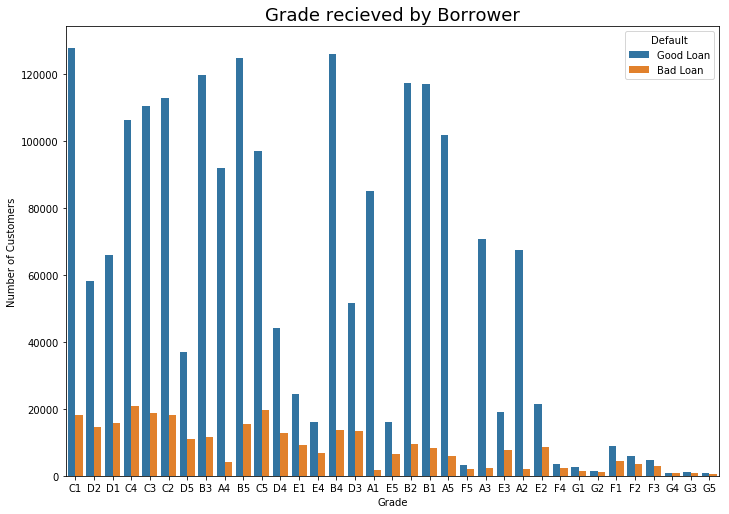

In [ ]:
grade = red_df.select('grade', 'sub_grade', 'Default').toPandas()

fig, ax = plt.subplots(figsize = a4_dims)

sns.countplot(x='sub_grade',hue='Default',data=grade)
# sns.distplot(grade['sub_grade'] , color = 'blue')
ax.set_title('Grade recieved by Borrower', fontsize = 18)
ax.set_xlabel('Grade')
ax.set_ylabel('Number of Customers')

Text(0, 0.5, 'Number of Customers')

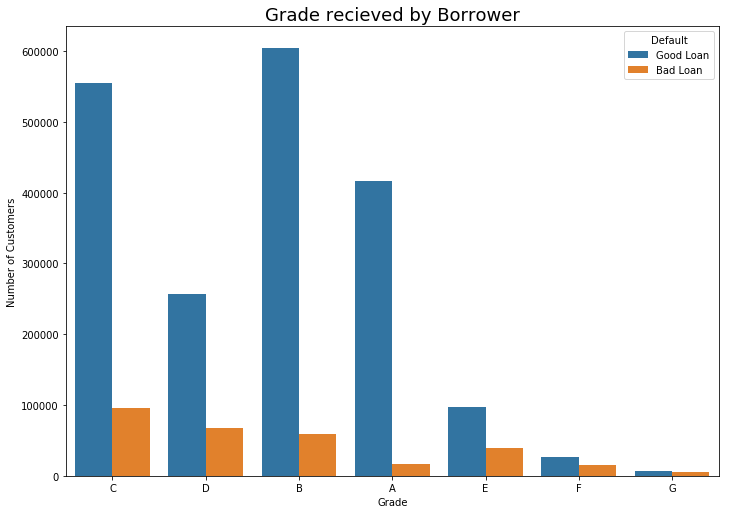

In [ ]:
grade = red_df.select('grade', 'sub_grade', 'Default').toPandas()

fig, ax = plt.subplots(figsize = a4_dims)

sns.countplot(x='grade',hue='Default',data=grade)
# sns.distplot(grade['sub_grade'] , color = 'blue')
ax.set_title('Grade recieved by Borrower', fontsize = 18)
ax.set_xlabel('Grade')
ax.set_ylabel('Number of Customers')

In [ ]:
feat_cat.extend(['grade', 'sub_grade'])

### 6. Employ Title

In [ ]:
red_df.groupBy('emp_title').count().orderBy('count', ascending = False).show()

+------------------+------+
|         emp_title| count|
+------------------+------+
|              null|166931|
|           Teacher| 38824|
|           Manager| 34298|
|             Owner| 21977|
|  Registered Nurse| 15867|
|            Driver| 14753|
|                RN| 14737|
|        Supervisor| 14297|
|             Sales| 13050|
|   Project Manager| 10971|
|    Office Manager|  9772|
|   General Manager|  9251|
|          Director|  8934|
|             owner|  8507|
|         President|  7660|
|          Engineer|  7304|
|           manager|  7060|
|           teacher|  6692|
|Operations Manager|  6128|
|    Vice President|  5874|
+------------------+------+
only showing top 20 rows



In [ ]:
df1 = red_df.fillna('Unemp', subset = ['emp_title'])

title = df1.select('emp_title', 'Default').toPandas()

fig, ax = plt.subplots(figsize = a4_dims)

sns.countplot(x='emp_title',hue='Default',data=title)
# sns.distplot(grade['sub_grade'] , color = 'blue')
ax.set_title('Employment title of Borrower', fontsize = 18)
ax.set_xlabel('Title')
ax.set_ylabel('Number of Customers')

In [ ]:
feat_cat.append('emp_title')

### 7. Employment Length

In [ ]:
df1 = df1.fillna('U', subset=['emp_length'])
df1 = red_df.where(~df.emp_length.isin([' reactors"']))
df1 = df1.fillna('U', subset = ['emp_length'])
df1 = df1.withColumn("employment_length", F.when((F.col('emp_length') == 'U') ,0).
                     when((F.col('emp_length') == '< 1 year') ,1).
                     when((F.col('emp_length')== '1 year') ,2).
                     when((F.col('emp_length') == '2 years') ,3).
                     when((F.col('emp_length') == '3 years') ,4).
                     when((F.col('emp_length') == '4 years') ,5).
                     when((F.col('emp_length') == '5 years') ,6).
                     when((F.col('emp_length') == '6 years') ,7).
                     when((F.col('emp_length')== '7 years') ,8).
                     when((F.col('emp_length') == '8 years') ,9).
                    when((F.col('emp_length') == '9 years') ,10).otherwise(11))
df2 = df1.drop('emp_length')

cat_feat.append('employment_length')
df2.groupBy(['employment_length']).count().orderBy('employment_length', ascending = True).show(15,  truncate = False)

### 8. HomeOwnership

In [ ]:
df2.groupBy(['home_ownership']).count().orderBy('count', ascending = False).show(truncate = False)

In [ ]:
df2 = df1.withColumn("home_own", 
   F.when((df1.home_ownership == 'ANY') | (df1.home_ownership == 'OTHER') | (df1.home_ownership == 'NONE') ,'ETC').otherwise(df1.home_ownership))
cat_feat.append('home_own')
df2.drop('home_ownership')
df2.groupBy(['home_own']).count().orderBy('count', ascending = False).show(truncate = False)

### 9. Annual_inc, dti

In [ ]:
df2 = df2.dropna(subset = ['annual_inc', 'dti'])
df2.describe( 'annual_inc', 'dti').show()

In [ ]:
feat_num.extend(['annual_inc, dti'])

### 10. Verification Status

In [ ]:
df2.groupBy(['verification_status']).count().orderBy('count', ascending = False).show(truncate = False)

In [ ]:
cat_feat.append('verification_status')

### 11. Issue Date

In [ ]:
df2.groupBy(['issue_d']).count().orderBy('count', ascending = False).show(truncate = False)

In [ ]:
df3 = df2.withColumn('year_issued', df1['issue_d'].substr(5, 4))
df3.groupBy('year_issued').count().orderBy('year_issued', ascending = False).show()

### 12.Purpose

In [ ]:
purp_list = ['debt_consolidation', 'credit_card', 'home_improvement', 'other', 'major_purchase', 'medical', 'small_buisness', \
             'car', 'vacation', 'moving', 'house', 'wedding', 'renewable_energy', 'educational']

df3 = df3.where(df.emp_length.isin([' reactors"']))

In [ ]:
df3 = df3.drop('purpose', 'title')

In [ ]:
feat_cat.append('purpose')
df3.groupBy(['purpose']).count().show(15,  truncate = False)

### 13. Address States

In [ ]:
us_states = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID', 'AZ', 'TX', 'NM', 'OK', 'GA', 'NC', 'VA', 'FL', 'KY',\
             'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN', 'IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN',\
             'ND','CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']

df3 = df3.where(df.addr_state.isin(us_states))
feat_index.append('addr_state')
feat_cat.append('addr_state')

df3.groupBy(['addr_state']).count().show(15,  truncate = False)

In [ ]:
df3.groupBy(['addr_state']).count().show(truncate = False)

### 14. Crossed 30 day grace period in last 2 years

In [ ]:
df3.groupBy('delinq_2yrs').distinct()..show(truncate = True)

In [ ]:
df3.groupBy('delinq_2yrs').count().orderBy('delinq_2yrs', asscending = False).show(truncate = True)

### 15.Accounts on Deliquent

In [ ]:
df3 = df3.where(~df3.acc_now_delinq.isin(['Feb-2017', 'Individual']))
df3 = df3.withColumn("delinquent_account", 
   F.when((df2.acc_now_delinq == '0.0') | (df2.acc_now_delinq == '0') ,0).otherwise(df2.acc_now_delinq))

df3 = df3.drop('acc_now_delinq')